# Introduction

Saviez vous que les commentaires que vous postez sont analysés? Sur Facebook par exemple, avant que vous ne publiez un commentaire, l'IA (Intelligence Artificielle) de Facebook décortique votre commentaire et juge de son caractère avant de décider s'il le poste ou le rejète[^1].
 Dans la même optique, Youtube effectue un travail similaire. Si dans vos paramètres, vous décidez de faire vérifier les commentaires avant publication, l'IA effectue le travail pour vous. La question est de savoir comment l'IA réalise cette tâche. Fait elle des suppositions? Masque t'elle simplement les commentaires des comptes nuisibles? 

Dans cet article, nous essayons de répondre à cette question. On vous présentera tout au long le processus de création de cet outil qui a pour but d'analyser et de juger de la qualité d'un commentaire. Pour réaliser cette tâche, nous avons recueilli un ensemble de commentaires/posts twitter concernant la marque Apple. Les étapes pour la réalisation de ce travail sont résumés par le schéma suivant: 

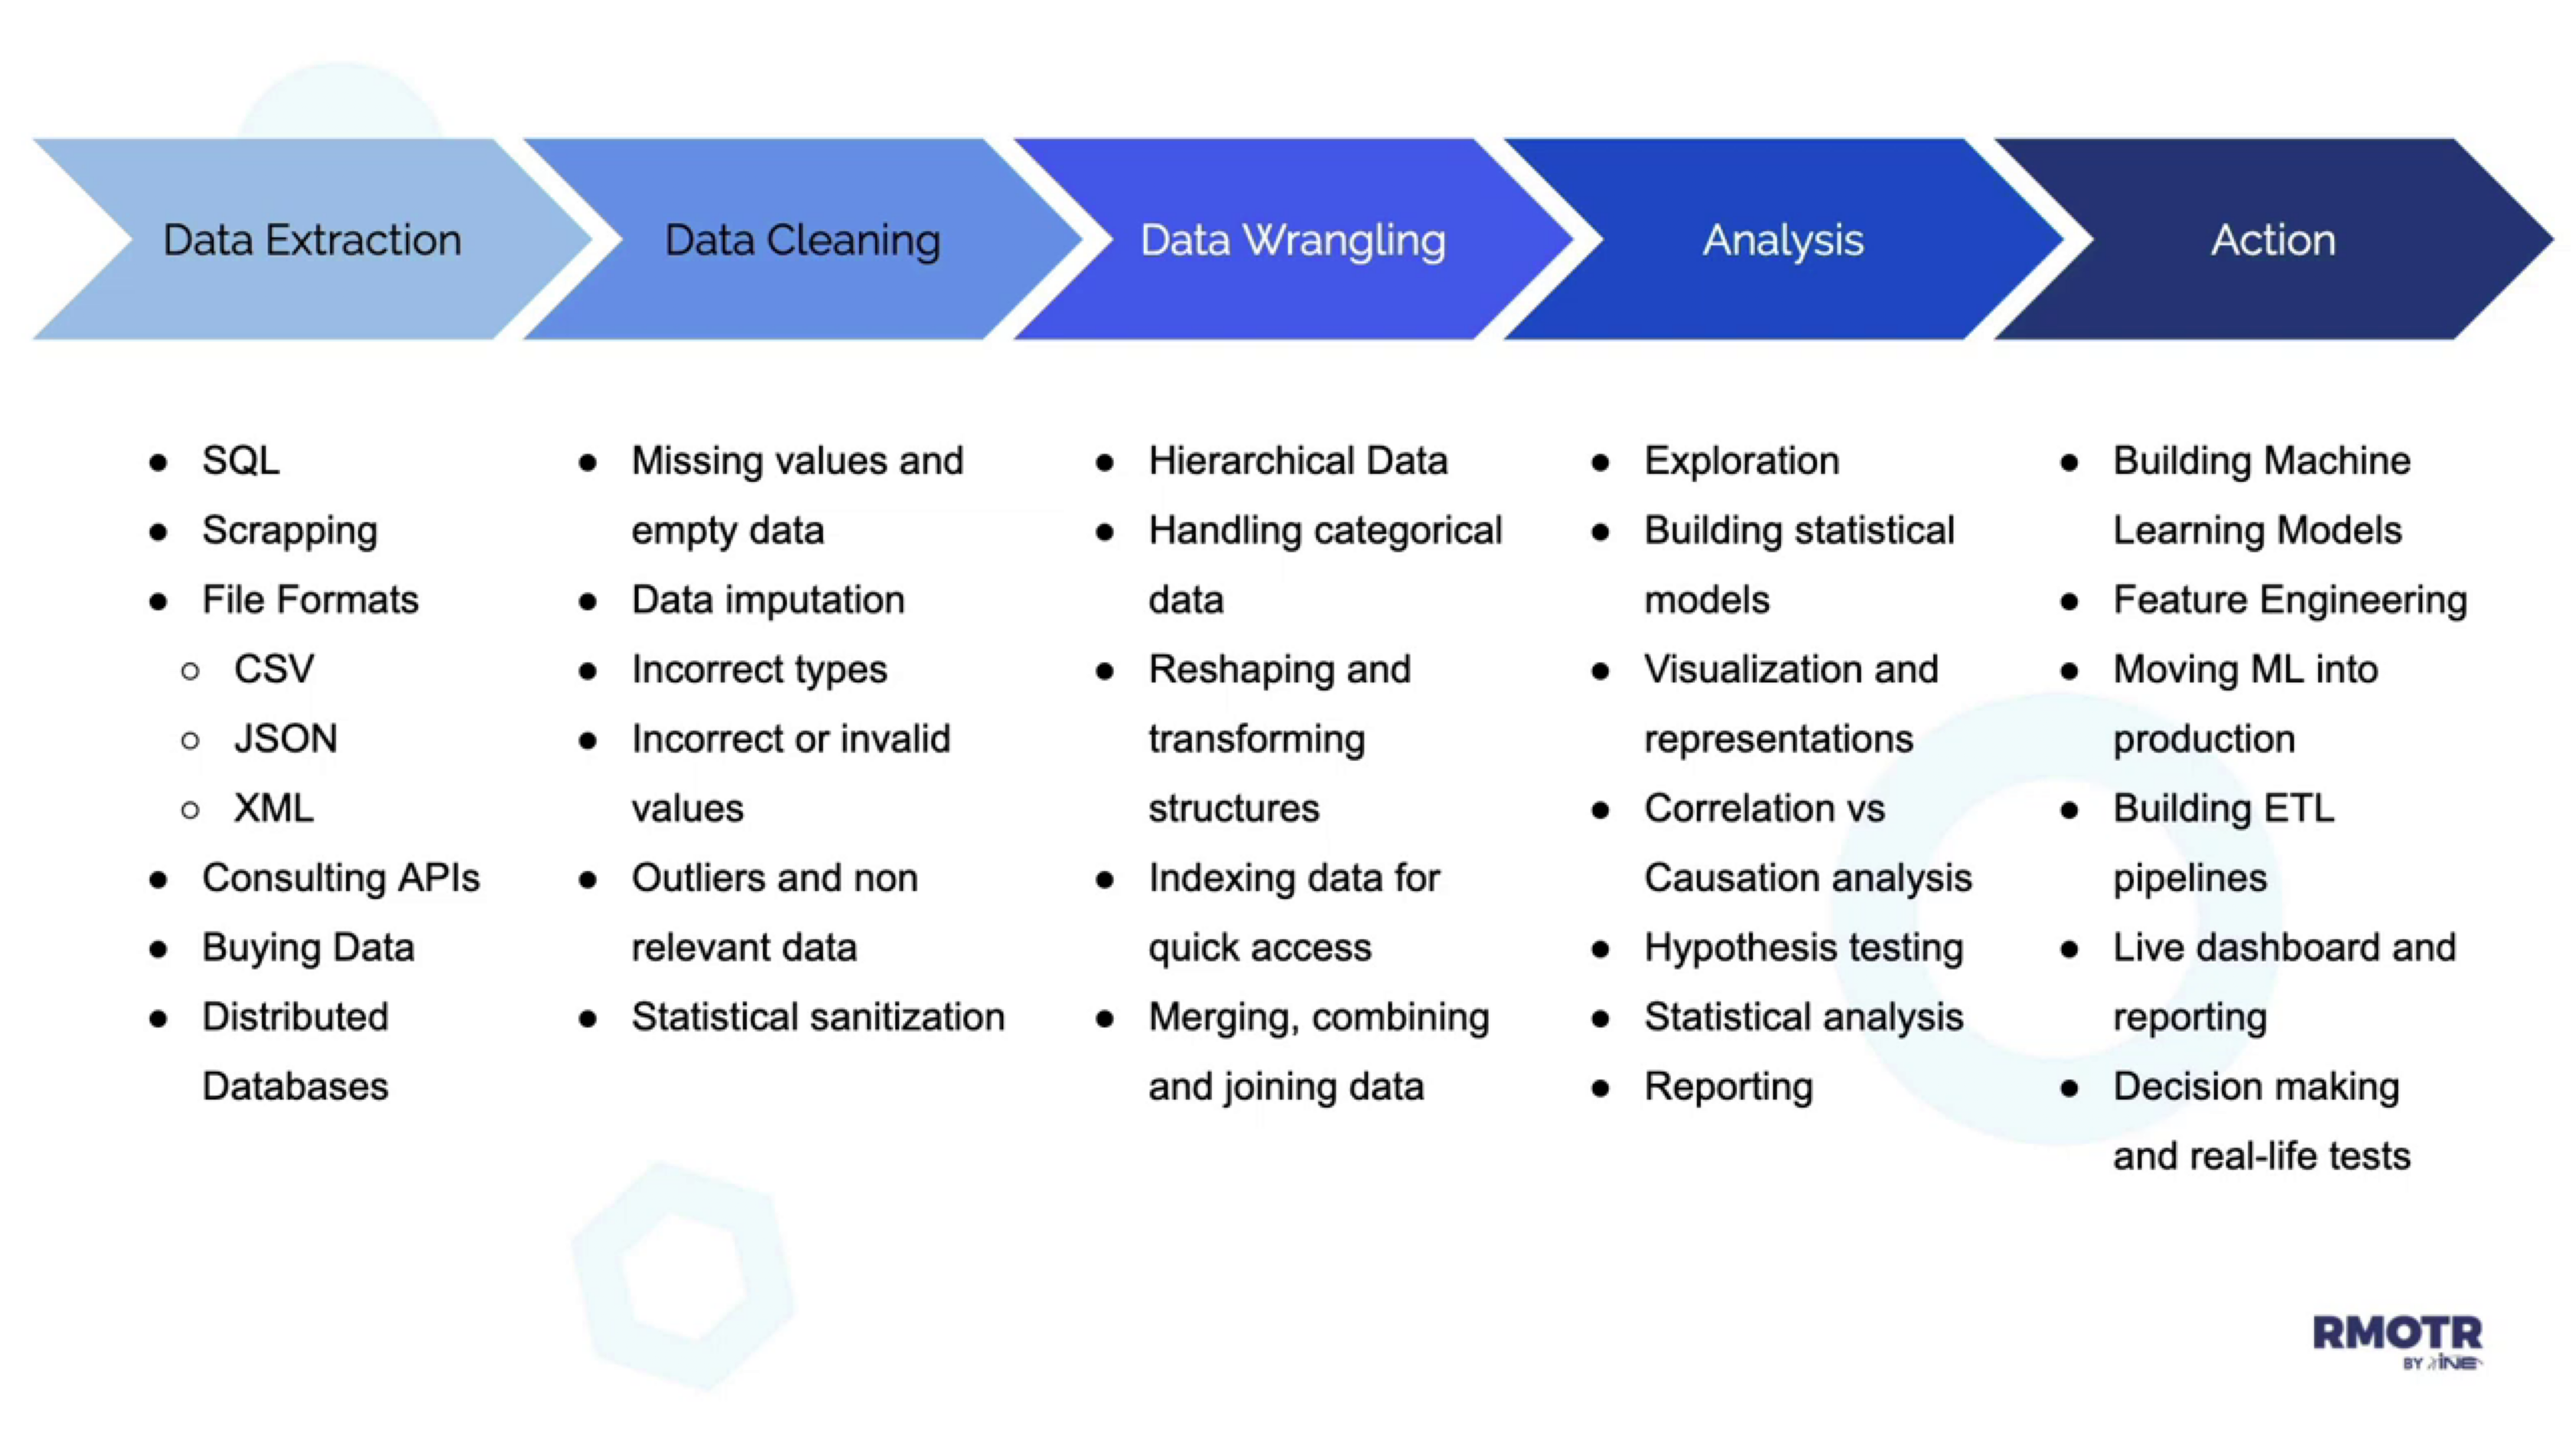

In [ ]:
import matplotlib.image as mpimg

img = mpimg.imread('CRISP-DM.png')
fig = plt.figure(figsize = (60,35))
plt.axis('off')
imgplot = plt.imshow(img)

Asseyez vous confortablement, attachez votre ceinture, et laissez nous vous conduire dans cette aventure.

## 1. Importation des données

Avant de commencer, nous allons déjà importé les données qui nous permettront d'effectuer nos travaux. Généralement, les entreprises collectent ces données et en font une grande base de données pour entrainer leur IA et les rendre plus efficace. Dans notre cas, nous avons utilisé des données déjà collectées.

In [ ]:
#Importation des bibliothèques
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 

In [ ]:
#Création du dataframe data contenant les données a traité
data = pd.read_csv("apple-twitter-sentiment-texts.csv")

Après importation, on peut observer à quoi ressemble notre dataset. Il possède trois colonnes:
- La colonne des index: Elle ne contient que les index. Ces index permettent de retrouver le numéro d'une ligne en particulier
- text: Elle contient le texte d'un utilisateur
- sentiment: Elle possède trois valeurs et donne le sentiment de l'auteur du texte (-1 = Négatif; 0 = Neutre; 1 = Positif)

In [ ]:
data.head()

,text,sentiment
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0


In [ ]:
#Comptage du nombre des différents sentiments
data.sentiment.value_counts()

 0    801
-1    686
 1    143
Name: sentiment, dtype: int64

## 2. Nettoyage des données 

### a. Vérification de base

Ici, on fait ce que l'on considère comme le nettoyage de base. On supprime les valeurs nulles (après s'être assuré qu'ils sont en petits nombres) et les valeurs répétitives

In [ ]:
#Comptage des valeurs vides dans le dataset
data.text.isna().sum()

0

In [ ]:
#Suppression des lignes de textes répétitives
data = data.drop_duplicates(subset = 'text', keep ='first', ignore_index = True)

### b. Suppression des éléments inutiles dans les textes

Dans les textes des utilisateurs, il y'a un ensemble d'éléments non pertinents pour notre outil de prédiction et même compromettantes pour notre analyse. Il s'agit :
- Des identifiants de comptes (Ex: @Apple): Non pertinent car ne permet pas de se faire une opinion sur le sentiment. Il désigne simplement une personne ou une entité.
- Des liens url (Ex: http://t.co/cKdkibI6PL): Non pertinent car ne permet pas de se faire une opinion sur le sentiment. C'est son contenu qui le fait et nous n'analysons pas le contenu du lien url.
- Des hashtags (Ex: #aapl): Non pertinent car ne permet pas de se faire une opinion sur le sentiment. Il définit un sujet sans pour autant préciser l'avis de l'utilisateur.

Pour réaliser la suppression de ces éléments, on utilise ce que l'on appelle en langage informatique les "Regular Expression" (ou RegEx). Une RegEx est une séquence de caractères qui définit un modèle de recherche. Il permet de retrouver une chaine de caractères dans une phrase. Ainsi, on peut ressortir dans une phrase uniquement les liens, ou hashtag.

In [ ]:
#Importation des bibliothèques permettant l'utilisation des regular expressions
import re 
import random 

In [ ]:
#Fonction de suppression des expressions définies
def clean(txt): 
  x = re.sub("(RT )?@[\S]+","", txt) #remplace l'ensemble des mots commençant par un arobase (@) tag par un vide
  x = re.sub("(https?:\/\/|www\.)[a-zA-Z0-9-_\.\/\?=&]+","", x) #remplace l'ensemble des lien url par un vide
  x = re.sub("#[\S]+","",x) #remplace l'ensemble des hashtag par un vide
  return x

In [ ]:
#Application de la fonction des cleans sur chaque ligne de la colonne text
data.text = data.text.apply(lambda v: clean(v))

A la fin du nettoyage, on obtient le tableau suivant, privé de l'ensemble des éléments non pertiments. 

In [ ]:
data

,text,sentiment
0,Wow. Yall needa step it up Music and snapcha...,-1
1,What Happened To Apple Inc?,0
2,Thank u I can now compile all of the pics tha...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,can i exchange my iphone for a different colo...,0
...,...,...
1619,Those** PICK UP THE SLACK YOU FUCK BOYS,-1
1620,Finally got my iPhone 6 in the mail and it com...,-1
1621,ended up getting a new computer anyhow (work...,0
1622,The 19-Year-Old Who Turned Down Has Nabbed B...,0


## 3. Structuration des données

Dans cette étape, on réalise un préparation des données pour l'analyse et le test sur l'outil de prédiction. On s'assure d'améliorer la structure des données pour qu'elle soit appropriée pour les analyses. 
On réalise cette étape en trois parties:
- La normalisation des données
- La suppression du bruit dans les textes
- La densité des mots

### a. La normalisation des données

La normalisation des données consiste à découper les phrases en liste de mot. Par exemple, on veut pouvoir transformer la phrase "Il fait beau" en une liste contenant les mots [il, fait, beau]. Cette opération s'appelle la "tokenisation" et la liste de mots un "token". Pour réaliser la tokenisation, on utilise la bibliothèques nltk et différents packages permettant de reconnaitre et transformer un verbe (ou un adjectif) conjugué en sa racine la plus proche.

Ensuite, il faudra transformer les mots conjuguées (et adjectifs) en leur infinitif (et racine). Ceci ce fait à l'aide des outils de "lemmatization" et/ou de "stemming". Pour la phrase de notre exemple, on se retrouvera avec la liste [il, faire, beau].

Le but de cette normalisation est d'éviter que notre outil de prédiction considère deux mots ayant le même sens (faisait et fait) comme deux mots différents.

In [ ]:
#Importation de la bibliothèque nécessaire pour la tokenisation
import nltk

In [ ]:
#Téléchargement du package punkt et du package wordnet
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# Importation des modules de nltk
from nltk.tag import pos_tag # réference l'utilité du mot dans une phrase
from nltk.stem.wordnet import WordNetLemmatizer # outil lemmatizer basée sur le dictionnaire wordnet
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Sachant qu'il existe plusieurs processus de tokenisation. Nous avons utilisé trois outils de tokenisation (Stemm Porter, Stemm Snowball, Lemmatizer) et à partir d'un exemples et des résultats obtenus, nous avons fait un choix suivant l'outil le plus efficace.

In [ ]:
# Génération d'un token aléatoire
index = random.choice(range(data.shape[0]))
test = data.text.apply(lambda row: nltk.word_tokenize(row))[index]
test = [ word.lower() for word in test]
data.text[index]

"Changing words that aren't even misspelled like where do they REALLY do that at???? I would really like to know. "

In [ ]:
# Transformations du text 
# Stemm Porter
def porterstem(liste):
    return [nltk.stem.PorterStemmer().stem(word) for word in liste]
# Stemm Snow
def snowballstem(liste):
    return [nltk.stem.SnowballStemmer("english").stem(word) for word in liste]
# Lemma 
def lemmatize_sentence(tokens):
   lemmatizer = WordNetLemmatizer()
   lemmatized_sentence = []
   for word, tag in pos_tag(tokens):
       if tag.startswith('NN'):
           pos = 'n'
       elif tag.startswith('VB'):
           pos = 'v'
       else:
           pos = 'a'
       lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
   return lemmatized_sentence

In [ ]:
# Comparaison des différentes transformations
pd.DataFrame(list(zip(test,porterstem(test),snowballstem(test),lemmatize_sentence(test))),columns=['original','PorterStem','SnowballStem','lemmatize_sentence'])

,original,PorterStem,SnowballStem,lemmatize_sentence
0,changing,chang,chang,change
1,words,word,word,word
2,that,that,that,that
3,are,are,are,be
4,n't,n't,n't,n't
5,even,even,even,even
6,misspelled,misspel,misspel,misspell
7,like,like,like,like
8,where,where,where,where
9,do,do,do,do


Après  comparaison, nous avons décider d'utiliser l'outil lemmatizer. Dans la suite nous appliquons la transformation dont le résultat sera classée dans des colonnes que l'on aura ajouté à notre dataframe.

In [ ]:
#Création des tokens à partir de la fonction word_tokenize de la bibliothèque nltk
data['token'] = data.text.apply(lambda row: nltk.word_tokenize(row))

In [ ]:
#Application de la fonction lemmatize_sentence sur chaque ligne de la colonne token et le résultat sera inscrit sur la colonne token_transform
data['token_transform'] =  data.token.apply(lambda row: lemmatize_sentence(row))

In [ ]:
data.head()

,text,sentiment,token,token_transform
0,Wow. Yall needa step it up Music and snapcha...,-1,"[Wow, ., Yall, needa, step, it, up, Music, and...","[Wow, ., Yall, needa, step, it, up, Music, and..."
1,What Happened To Apple Inc?,0,"[What, Happened, To, Apple, Inc, ?]","[What, Happened, To, Apple, Inc, ?]"
2,Thank u I can now compile all of the pics tha...,1,"[Thank, u, I, can, now, compile, all, of, the,...","[Thank, u, I, can, now, compile, all, of, the,..."
3,The oddly uplifting story of the Apple co-foun...,0,"[The, oddly, uplifting, story, of, the, Apple,...","[The, oddly, uplifting, story, of, the, Apple,..."
4,can i exchange my iphone for a different colo...,0,"[can, i, exchange, my, iphone, for, a, differe...","[can, i, exchange, my, iphone, for, a, differe..."


### b. Suppression du bruit dans les textes

Qu'est ce qu'on appelle un bruit dans le texte? Un bruit est simplement un mot qui n'apporte aucune information pertinente dans le texte. Vous pourriez vous demandez: n'est ce pas ce que nous avons déjà réalisé plus haut? La réponse à cette question est oui, mais pas totalement. Les regex ne permettent que de recupérer un certain groupe de mots (des lettres, des chiffres, des symboles, etc.) Elles ne permettent pas par exemple de supprimer "I" de "I will" sans supprimer le "I" de "will". 

Pour ce genre d'opérations, on utilise un autre outil que l'on appelle "stopwords". Les stopwords permettent simplement de retirer les mots communs à un langage (les pronoms, les prépositions, etc.). En plus de ces éléments nous allons aussi supprimer les ponctuations.

In [ ]:
#Téléchargement de la liste des mots non porteur de sens communs anglais (comme i, a, etc.)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Importation de ces mots
from nltk.corpus import stopwords
stopword =  stopwords.words('english') # Téléchargement de la bibliothèque de mots non porteurs de sens (stopwords)

In [ ]:
# Fonction pour éliminer les stopwords et les ponctuations
def clean_stop(token):
  token = [re.sub("[^\w\s]","",x) for x in token] # Suppression des signes de ponctuation 
  token = [words for words in token if words.lower() not in stopword] # suppression des stopwords de la liste
  return [x.lower() for x in token if x] # Suppresion des valeurs vides dans la liste

In [ ]:
#Nettoyage de nos tokens à l'aide de la fonction clean_stop
data['clean_token'] = data.token_transform.apply(lambda mots : clean_stop(mots))

In [ ]:
# On définit d'abord une fonction qui va permettre de retirer les signes de ponctuation sur la colonne text
def clean_txt(txt):
  txt = re.sub("[^\w\s]","",txt)
  return txt

In [ ]:
data['clean_txt'] = data['text'].apply(lambda x : clean_txt(x))

In [ ]:
data.head()

,text,sentiment,token,token_transform,clean_token,clean_txt
0,Wow. Yall needa step it up Music and snapcha...,-1,"[Wow, ., Yall, needa, step, it, up, Music, and...","[Wow, ., Yall, needa, step, it, up, Music, and...","[wow, yall, needa, step, music, snapchat, damn...",Wow Yall needa step it up Music and snapchat...
1,What Happened To Apple Inc?,0,"[What, Happened, To, Apple, Inc, ?]","[What, Happened, To, Apple, Inc, ?]","[happened, apple, inc]",What Happened To Apple Inc
2,Thank u I can now compile all of the pics tha...,1,"[Thank, u, I, can, now, compile, all, of, the,...","[Thank, u, I, can, now, compile, all, of, the,...","[thank, u, compile, pic, communicate, one, place]",Thank u I can now compile all of the pics tha...
3,The oddly uplifting story of the Apple co-foun...,0,"[The, oddly, uplifting, story, of, the, Apple,...","[The, oddly, uplifting, story, of, the, Apple,...","[oddly, uplifting, story, apple, cofounder, se...",The oddly uplifting story of the Apple cofound...
4,can i exchange my iphone for a different colo...,0,"[can, i, exchange, my, iphone, for, a, differe...","[can, i, exchange, my, iphone, for, a, differe...","[exchange, iphone, different, color, lmao, cha...",can i exchange my iphone for a different colo...


### c. Densité des mots

Cette étape consiste à regrouper les mots qui reviennent le plus souvent suivant les sentiments qu'ils renvoient. Nous utiliserons ces éléments plus tard pour la visualisation et l'analyse.

In [ ]:
from nltk.util import ngrams
from nltk import FreqDist

In [ ]:
#Création d'une liste qui contient l'ensemble des mots à sens négatif
all_negative = []
for i in data.clean_token[data.sentiment == -1]:
  for element in i:
    all_negative.append(element)

In [ ]:
#Création d'un dataframe contenant l'ensemble des 30 mots à sens négatif les plus communs et leurs répétitions
freq_dist_neg = FreqDist(all_negative)
freq_dist_neg = freq_dist_neg.most_common(30)
freq_dist_neg = pd.DataFrame(freq_dist_neg,columns=["Words","Repetitions"])

In [ ]:
#Création d'une liste qui contient l'ensemble des commentaires neutres
all_neutral = []
for i in data.clean_token[data.sentiment == 0]:
  for element in i:
    all_neutral.append(element)

In [ ]:
#Création d'un dataframe contenant l'ensemble des 30 mots à sens neutre les plus communs et leurs répétitions
freq_dist_neu = FreqDist(all_neutral)
freq_dist_neu = freq_dist_neu.most_common(30)
freq_dist_neu = pd.DataFrame(freq_dist_neu,columns=["Words","Repetitions"])

In [ ]:
#Création d'une liste qui contient l'ensemble des commentaires positifs
all_positive = []
for i in data.clean_token[data.sentiment == 0]:
  for element in i:
    all_positive.append(element)

In [ ]:
#Création d'un dataframe contenant l'ensemble des 30 mots à sens positif les plus communs et leurs répétitions
freq_dist_pos = FreqDist(all_positive)
freq_dist_pos = freq_dist_pos.most_common(30)
freq_dist_pos = pd.DataFrame(freq_dist_pos,columns=["Words","Repetitions"])

A la fin, pour chaque type de sentiment, on obtient un tableau similaire à celui présenté plus bas. Il contient le mot et le nombre de fois qu'il est retrouvé.

In [ ]:
freq_dist_neg[:10]

,Words,Repetitions
0,fuck,111
1,nt,111
2,phone,104
3,shit,67
4,get,66
5,iphone,65
6,apple,52
7,fix,52
8,make,48
9,charger,42


On se rend compte avec cette visualisation de l'existance des termes qui ne font pas beaucoup de sens comme 'nt', 'u'. Après recherche, nous nous sommes rendus compte qu'il existe des groupes de mots qui ont plus de sens si l'outil de prédiction les considère comme un seul mot. (Ex: iPhone 6 -> iPhone, Apple Inc -> AppleInc)

Pour réussir à obtenir ce que l'on souhaite, nous allons regrouper les mots deux à deux et pour chaque sentiment, et pour chaque on va observer le groupe de mots le plus fréquents et prendre ceux qui ont une fréquence supérieur à 9 (nous avons testé les valeurs en dessous, mais le changement sur la précision de notre outil de prédiction n'est pas significatif).

In [ ]:
#Importation de l'outil ngrams
from nltk.util import ngrams
n = 2 #Définition du nombre de mots à découper

In [ ]:
#Création de la fonction bigram qui regroupe dans un tuple tous les deux mots d'une phrase
def bigram(token,i=n):
  grams = ngrams(token,i)
  result = []
  for i in grams :
    result.append(i)
  return result

In [ ]:
#Application de la fonction bigram sur l'ensemble des lignes de la colonne "clean_token"
data['bigram'] = data['clean_token'].apply(lambda token : bigram(token))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: generator 'ngrams' raised StopIteration
  """


In [ ]:
#Création des listes contenant les groupes de mots de chaque phrase
all_2_negative = []
for i in data.bigram[data.sentiment == -1]:
  for element in i:
    all_2_negative.append(element)

all_2_positive = []
for i in data.bigram[data.sentiment == 1]:
  for element in i:
    all_2_positive.append(element)

all_2_neutral = []
for i in data.bigram[data.sentiment == 0]:
  for element in i:
    all_2_neutral.append(element)

In [ ]:
# Dataframe de tuples à Sentiment négative
freq_dist_2_neg = FreqDist(all_2_negative)
freq_dist_2_neg = freq_dist_2_neg.most_common(30)
freq_dist_2_neg = pd.DataFrame(freq_dist_2_neg,columns=["Words","Repetitions"])

# Dataframe de tuples à Sentiment neutre
freq_dist_2_neu = FreqDist(all_2_neutral)
freq_dist_2_neu = freq_dist_2_neu.most_common(30)
freq_dist_2_neu = pd.DataFrame(freq_dist_2_neu,columns=["Words","Repetitions"])

# Dataframe de tuples à Sentiment positif
freq_dist_2_pos = FreqDist(all_2_positive)
freq_dist_2_pos = freq_dist_2_pos.most_common(30)
freq_dist_2_pos = pd.DataFrame(freq_dist_2_pos,columns=["Words","Repetitions"])

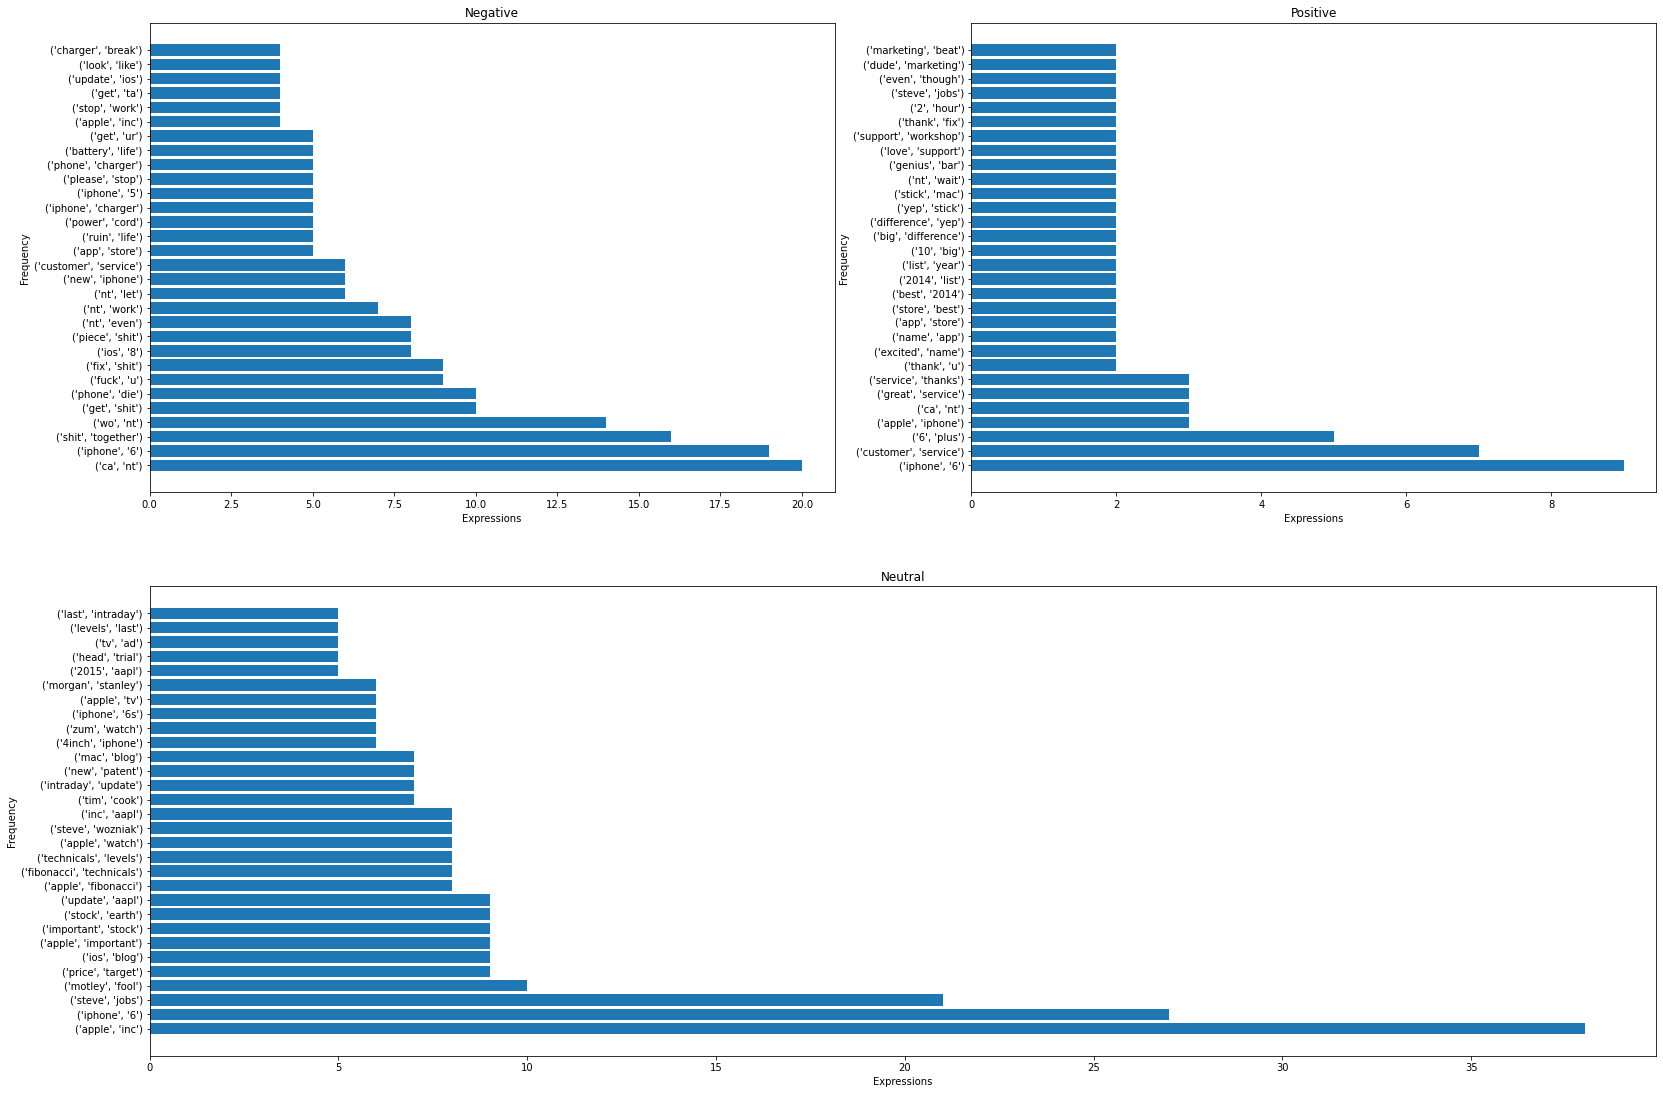

In [ ]:
#Histogramme des tuples des 30 premiers mots à sens négatif
label1 = freq_dist_2_neg.Words.apply(lambda x : str(x))
label2 = freq_dist_2_pos.Words.apply(lambda x : str(x))
label3 = freq_dist_2_neu.Words.apply(lambda x : str(x))

plt.figure(figsize=(27, 19))

ax1 = plt.subplot(221)
ax1.set_title('Negative')
ax1.barh(freq_dist_2_neu.Words.apply(lambda x : str(x)), freq_dist_2_neg["Repetitions"],tick_label = label1 )
plt.xlabel('Expressions')
plt.ylabel('Frequency')   

ax2 = plt.subplot(222)
ax2.set_title('Positive')
ax2.barh(freq_dist_2_pos.Words.apply(lambda x : str(x)), freq_dist_2_pos["Repetitions"])
plt.xlabel('Expressions')
plt.ylabel('Frequency')   

ax3 = plt.subplot(212)
ax3.set_title('Neutral')
ax3.barh(freq_dist_2_neu.Words.apply(lambda x : str(x)), freq_dist_2_neu["Repetitions"])
plt.xlabel('Expressions')
plt.ylabel('Frequency')   

 
plt.show()

A partir de ce graphe, on peut estimer les groupes de mots les plus fréquents et ceux supérieurs à 9. On prendra donc pour les 9 premiers groupes de mots négatifs, le 1 positif et les 4 neutres. Ceci permettra de finaliser une liste de groupe de mots que l'on regroupera.

In [ ]:
# Dataframe de tuples à Sentiment négative
freq_dist_2_neg = FreqDist(all_2_negative)
freq_dist_2_neg = freq_dist_2_neg.most_common(9)
freq_dist_2_neg = pd.DataFrame(freq_dist_2_neg,columns=["Words","Repetitions"])

# Dataframe de tuples à Sentiment neutre
freq_dist_2_neu = FreqDist(all_2_neutral)
freq_dist_2_neu = freq_dist_2_neu.most_common(4)
freq_dist_2_neu = pd.DataFrame(freq_dist_2_neu,columns=["Words","Repetitions"])

# Dataframe de tuples à Sentiment positif
freq_dist_2_pos = FreqDist(all_2_positive)
freq_dist_2_pos = freq_dist_2_pos.most_common(1)
freq_dist_2_pos = pd.DataFrame(freq_dist_2_pos,columns=["Words","Repetitions"])

In [ ]:
#Création d'une dataframe étant une fusion des trois dataframes différents.
freq_dist_2 = pd.concat([freq_dist_2_pos,freq_dist_2_neu,freq_dist_2_neg], axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True).reset_index().drop(columns = ["index"])

In [ ]:
#Création d'une fonction qui regroupe et remplace les mots existants dans une liste de mots
def replace_tuple (existant, liste_verif, txt):
  for element in existant:
    if element in liste_verif:
      try :
        txt.remove (element[0])
        txt.remove (element[1])
      except ValueError: continue
      txt.insert(0, "".join(element))
    else: txt = txt
  return txt

In [ ]:
#Application de la fonction replace_tuple qui permettra de remplacer les mots de la colonne clean_token par leurs groupes de mots associés
for i in range(len(data)):
 data["clean_token"][i] = replace_tuple(data.bigram[i],freq_dist_2.Words.tolist(),data.clean_token[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#Visualisation
data

,text,sentiment,token,token_transform,clean_token,clean_txt,bigram
0,Wow. Yall needa step it up Music and snapcha...,-1,"[Wow, ., Yall, needa, step, it, up, Music, and...","[Wow, ., Yall, needa, step, it, up, Music, and...","[wow, yall, needa, step, music, snapchat, damn...",Wow Yall needa step it up Music and snapchat...,"[(wow, yall), (yall, needa), (needa, step), (s..."
1,What Happened To Apple Inc?,0,"[What, Happened, To, Apple, Inc, ?]","[What, Happened, To, Apple, Inc, ?]","[appleinc, happened]",What Happened To Apple Inc,"[(happened, apple), (apple, inc)]"
2,Thank u I can now compile all of the pics tha...,1,"[Thank, u, I, can, now, compile, all, of, the,...","[Thank, u, I, can, now, compile, all, of, the,...","[thank, u, compile, pic, communicate, one, place]",Thank u I can now compile all of the pics tha...,"[(thank, u), (u, compile), (compile, pic), (pi..."
3,The oddly uplifting story of the Apple co-foun...,0,"[The, oddly, uplifting, story, of, the, Apple,...","[The, oddly, uplifting, story, of, the, Apple,...","[oddly, uplifting, story, apple, cofounder, se...",The oddly uplifting story of the Apple cofound...,"[(oddly, uplifting), (uplifting, story), (stor..."
4,can i exchange my iphone for a different colo...,0,"[can, i, exchange, my, iphone, for, a, differe...","[can, i, exchange, my, iphone, for, a, differe...","[exchange, iphone, different, color, lmao, cha...",can i exchange my iphone for a different colo...,"[(exchange, iphone), (iphone, different), (dif..."
...,...,...,...,...,...,...,...
1619,Those** PICK UP THE SLACK YOU FUCK BOYS,-1,"[Those**, PICK, UP, THE, SLACK, YOU, FUCK, BOYS]","[Those**, PICK, UP, THE, SLACK, YOU, FUCK, BOYS]","[pick, slack, fuck, boys]",Those PICK UP THE SLACK YOU FUCK BOYS,"[(pick, slack), (slack, fuck), (fuck, boys)]"
1620,Finally got my iPhone 6 in the mail and it com...,-1,"[Finally, got, my, iPhone, 6, in, the, mail, a...","[Finally, get, my, iPhone, 6, in, the, mail, a...","[iphone6, finally, get, mail, come, box, buste...",Finally got my iPhone 6 in the mail and it com...,"[(finally, get), (get, iphone), (iphone, 6), (..."
1621,ended up getting a new computer anyhow (work...,0,"[ended, up, getting, a, new, computer, anyhow,...","[end, up, get, a, new, computer, anyhow, (, wo...","[end, get, new, computer, anyhow, work, comput...",ended up getting a new computer anyhow work ...,"[(end, get), (get, new), (new, computer), (com..."
1622,The 19-Year-Old Who Turned Down Has Nabbed B...,0,"[The, 19-Year-Old, Who, Turned, Down, Has, Nab...","[The, 19-Year-Old, Who, Turned, Down, Has, Nab...","[19yearold, turned, nabbed, backing, star]",The 19YearOld Who Turned Down Has Nabbed Bac...,"[(19yearold, turned), (turned, nabbed), (nabbe..."


On observe bien que les mots comme iPhone et 6 ne forment plus qu'un mot (visible sur la ligne 1623 )

## 4. Visualisation des données

La visualisation va aider à observer facilement, les mots qui reviennent le plus suivant chaque sentiment. Nous allons pour la visualisation réalisée deux visualisations principales:
- Wordcloud: Nuage de mots avec les polices la plus grande pour le mot le plus fréquent
- Scattertext: Outil permettant de visualiser sur une repère à deux axes les mots qui reviennent le plus ainsi qu'un code couleur pour les séparer

### a. Wordcloud

- Pour les mots à sens *positifs*

In [ ]:
#Création d'une liste qui contient l'ensemble des mots à sens négatif
all_negative = []
for i in data.clean_token[data.sentiment == -1]:
  for element in i:
    all_negative.append(element)
    
freq_dist_neg = FreqDist(all_negative)
freq_dist_neg = freq_dist_neg.most_common(30)
freq_dist_neg = pd.DataFrame(freq_dist_neg,columns=["Words","Repetitions"])

In [ ]:
#Création d'une liste qui contient l'ensemble des commentaires neutres
all_neutral = []
for i in data.clean_token[data.sentiment == 0]:
  for element in i:
    all_neutral.append(element)
    
freq_dist_neu = FreqDist(all_neutral)
freq_dist_neu = freq_dist_neu.most_common(30)
freq_dist_neu = pd.DataFrame(freq_dist_neu,columns=["Words","Repetitions"])

In [ ]:
#Création d'une liste qui contient l'ensemble des commentaires positifs
all_positive = []
for i in data.clean_token[data.sentiment == 0]:
  for element in i:
    all_positive.append(element)
    
freq_dist_pos = FreqDist(all_positive)
freq_dist_pos = freq_dist_pos.most_common(30)
freq_dist_pos = pd.DataFrame(freq_dist_pos,columns=["Words","Repetitions"])

In [ ]:
!pip install wordcloud

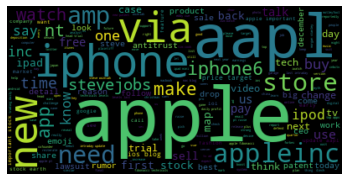

In [ ]:
#Création d'un worldcloud qui présentera les mots positifs qui reviennent le plus
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
separator = ', '
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords).generate(separator.join(all_positive))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- Pour les mots à sens *neutres*


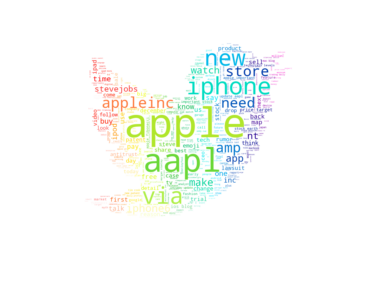

In [ ]:
from PIL import Image

# Generate a word cloud image
mask = np.array(Image.open("logoapple6.jpg"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(separator.join(all_neutral))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[8,5])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

- Pour les mots à sens *négatifs*

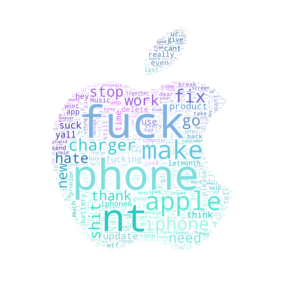

In [ ]:
from PIL import Image

# Generate a word cloud image
mask = np.array(Image.open("logoapple7.jpg"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(separator.join(all_negative))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[8,5])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

### e. Visualisation du Scatter Text

Il s'agit de visualiser globalement les mots sous forme de nuage de points. En python on dispose d'un outil assez pratique pour cela qui fournit également un ensembles d'outils assez sympa qui sont recensés dans un fichier html. Nous allons dons en générer un avec le code suivant :

In [ ]:
data["sentiment2"] = data["sentiment"].apply(lambda v : str(v))

In [ ]:
#Installation de la bibliothèque scatter text
!pip install scattertext
!pip install spacy

In [ ]:
#Création du scatter text
import spacy
import scattertext as st

nlp = spacy.load('en')
corpus = st.CorpusFromPandas(data,
                             category_col='sentiment2',
                             text_col='clean_txt',
                             nlp=nlp).build()
html = st.produce_scattertext_explorer(
    corpus,
    category="1", category_name='Positive', not_category_name='Negative',
    minimum_term_frequency=0, pmi_threshold_coefficient=0,
    width_in_pixels=1000, metadata=corpus.get_df()['sentiment2'],
    transform=st.Scalers.dense_rank
)
open('./demo_compact.html', 'w').write(html)
                            

4477506

Ce code permet de générer le document suivant (Attention l'ouverture peut prendre du temps) : [[demo_compact](https://github.com/FenixShadows/Stuff/blob/master/Articles/2-%20Tweeter%20Sentiment%20Analysis/demo_compact.html)]

## 5 - Construction de l'outil de prédiction :

Pour pouvoir effectuer la classification automatique des tweets, nous allons tout d'abord préparer nos données pour permettre à l'algorithme de s'entrainer. Ici la préparation est assez simple, on transforme l'ensemble des listes en un ensemble de chaine de caractères.

In [ ]:
# Fonction de conversion de liste en string   
def listToString(s):  
    str1 = ""  
    for ele in s:  
        ele = ele + " " 
        str1 += ele
    return str1  

In [ ]:
data["clean_token2"] = data["clean_token"].apply(lambda v : listToString(v))
data.head()

,text,sentiment,token,token_transform,clean_token,clean_txt,bigram,sentiment2,clean_token2
0,Wow. Yall needa step it up Music and snapcha...,-1,"[Wow, ., Yall, needa, step, it, up, Music, and...","[Wow, ., Yall, needa, step, it, up, Music, and...","[wow, yall, needa, step, music, snapchat, damn...",Wow Yall needa step it up Music and snapchat...,"[(wow, yall), (yall, needa), (needa, step), (s...",-1,wow yall needa step music snapchat damn time t...
1,What Happened To Apple Inc?,0,"[What, Happened, To, Apple, Inc, ?]","[What, Happened, To, Apple, Inc, ?]","[appleinc, happened]",What Happened To Apple Inc,"[(happened, apple), (apple, inc)]",0,appleinc happened
2,Thank u I can now compile all of the pics tha...,1,"[Thank, u, I, can, now, compile, all, of, the,...","[Thank, u, I, can, now, compile, all, of, the,...","[thank, u, compile, pic, communicate, one, place]",Thank u I can now compile all of the pics tha...,"[(thank, u), (u, compile), (compile, pic), (pi...",1,thank u compile pic communicate one place
3,The oddly uplifting story of the Apple co-foun...,0,"[The, oddly, uplifting, story, of, the, Apple,...","[The, oddly, uplifting, story, of, the, Apple,...","[oddly, uplifting, story, apple, cofounder, se...",The oddly uplifting story of the Apple cofound...,"[(oddly, uplifting), (uplifting, story), (stor...",0,oddly uplifting story apple cofounder sell sta...
4,can i exchange my iphone for a different colo...,0,"[can, i, exchange, my, iphone, for, a, differe...","[can, i, exchange, my, iphone, for, a, differe...","[exchange, iphone, different, color, lmao, cha...",can i exchange my iphone for a different colo...,"[(exchange, iphone), (iphone, different), (dif...",0,exchange iphone different color lmao change mind


Pour notre outil de prédiction, la valeur d'entrée sera les éléments de la colonne "clean_token2" qui regroupe les textes que propres que l'on a déjà nettoyé et structuré et la valeur de sortie sera les éléments de la colonne "sentiment" pour déterminer le résultat.

In [ ]:
x = data['clean_token2']
y = data['sentiment']

- Modèle 1

In [ ]:
#Importation du modèle et découpe des données de manière aléatoire (70% pour l'entrainement, 30% pour les tests)
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7, random_state=123)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words=stopword)
vecteur = count_vect.fit_transform(x_train)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(vecteur)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB()),])
text_clf = text_clf.fit(x_train, y_train)

In [ ]:
#Détermination de la précision de notre modèle
predicted = text_clf.predict(x_test)
np.mean(predicted == y_test)

0.7663934426229508

Ce modèle prédit de manière juste 76.64% le sentiment après entrainement.
Plus bas on peut voir un tableau présentant le sentiment réel et le sentiment prédit.

In [ ]:
predicted_df = pd.DataFrame(predicted)
y_test_df = pd.DataFrame(y_test).reset_index().drop(columns = ["index"])

In [ ]:
pred_y_concat = pd.concat([predicted_df,y_test_df], axis=1, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

In [ ]:
pred_y_concat = pred_y_concat.rename(columns={0:"predicted", "sentiment":"original value"})
pred_y_concat.head(10)

,predicted,original value
0,0,0
1,0,0
2,-1,-1
3,0,0
4,-1,0
5,-1,-1
6,-1,-1
7,-1,-1
8,0,0
9,0,0


- Modèle 2

Sachant que l'on souhaite obtenir l'outil de prédiction le plus efficace possible. Nous avons fait le test avec un deuxième outil de prédiction adapté à nos besoins.

In [ ]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words=stopword)),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter_no_change=5, random_state=42,shuffle=True, n_jobs=-1))
                         ])
_ = text_clf_svm.fit(x_train, y_train)
predicted_svm = text_clf_svm.predict(x_test)
np.mean(predicted_svm == y_test)

0.8155737704918032

Avec ce nouvel outil nous avons un meilleur score (81.56%). Mais l'écart n'est pas assez important pour écarter l'autre modèle. Nous allons mettre en place une grille qui va nous permettre de déterminer quels sont les paramètres les plus efficaces pour les modèles. 
Il faut préciser que cette valeur variera en fonction des paramètres (qui sont choisis de manière aléatoire dans ce cas) et de notre découpe aléatoire de jeu de données. Notre outil de prédiction n'est pas assez robuste.

Pour le rendre plus fort, on utilise le GridSearchCV (plus bas) qui permet d'identifier les paramètres les plus optimaux pour le modèle et ainsi le rendre plus robuste.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Paramètres optimaux pour le classifieur Multinomial
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3, 1e-4) 
              }
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(x_train, y_train)
print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.7940219491459928
{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


In [ ]:
# Paramètres optimaux pour le classifieur SVM
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
                  'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3, 1e-4)
                 }
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(x_train, y_train)
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.801951464564495
{'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


On atteint le score de 79.4% pour l'outil Pipeline et de  80.2 % pour l'outil SGDC Classifier à l'entrainement. Ces scores sont des valeurs plus fiables que les précédentes.
On va terminer en choisissant et en enregistrant le modèle en local.

In [ ]:
import pickle
# Enregistrer le meilleur modèle 
model_choisi = gs_clf_svm.best_estimator_
filename = 'model.sav'
pickle.dump(model_choisi, open(filename, 'wb'))

In [ ]:
# charger le modèle enregistré
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.8176229508196722


Notre modèle nous permet d'avoir un score de 81.76 % sur les données de test.

### Conclusion

La prédiction est un processus assez long. Toutes les étapes liées à ce processus doivent être effectuer minutieusement pour obtenir un outil encore plus précis. Nous avons tout au long de cette article, présenté de manière simple le processus commençant par le nettoyage jusqu'à l'implémentation des outils de prédictions. On peut résumer ce travail de préparation (avant l'utilisation des modèles) en une réduction de bruit. Le but ici est d'éliminer le plus d'informations superflues pour l'outil. Ainsi, l'outil peut se concentrer uniquement sur les données les plus importantes.

On retiendra de cet article les éléments importants pour le traitement de texte comme:
- La regex (Regular expression): Outil permettant de faire une recherche spécifique dans une chaine de caractères;
- Tokenisation: Outil permettant de découper une phrase en les mots qui la constitue;
- Lemmatisation et/ou Stemming: Outil permettant de transformer les mots conjugués ou accordés en leurs origines
- ngram: Outil permettant de découper une phrase en groupe de n mots la constituant

Après avoir effectué cette tâche, il serait intéressant de réfléchir sur les procédés utilisés par les applications pour nous protéger des contenus médias inappropriés.

## Sources

[^1]: Protalinski, "Is Facebook blocking 'irrelevant or inappropriate' comments?", ZDNet, Consulté le 08 Juillet 2020, https://www.zdnet.com/article/is-facebook-blocking-irrelevant-or-inappropriate-comments/